In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from src.data import data_layer
from src.model.model_utils import calculateStatistics
from src.model.model_utils import getFactorWithLargeCap
from src.model.model_GAN import FeedForwardModelWithNA_GAN_Ensembled
from src.model.model_RtnFcst import FeedForwardModelWithNA_Return_Ensembled
from src.utils import deco_print
from src.utils import load_dataframe
from src.utils import sharpe
from src.utils import max_1_month_loss
from src.utils import max_drawdown
from src.utils import eval_RtnFcst
from src.utils import construct_decile_portfolios
from src.utils import plot_decile_portfolios
from src.utils import plot_SMV
from src.utils import plot_SDF
from src.utils import plotReturnDecile
from src.utils import OLS
from src.utils import GRS
from src.utils import calculateStatisticsDecile
from src.utils import calculateStatisticsDoubleSorted5
from src.utils import calculateTurnover_with_dl

##### Model Configurations

In [2]:
logdirs = ['model_char_shift/model_GAN/%d' %k for k in range(1,10)]
with open(os.path.join('model_char_shift/model_GAN/config.json'), 'r') as file:
    config = json.load(file)
logdirs_RF = ['model_char_shift/model_GAN_RF_normalized/%d' %k for k in range(1,10)]
with open(os.path.join('model_char_shift/model_GAN_RF_normalized/config.json'), 'r') as file:
    config_RF = json.load(file)

##### Load Data

In [3]:
dl = data_layer.DataInRamInputLayer(config['individual_feature_file'],
                                    pathMacroFeature=config['macro_feature_file'])
meanMacroFeature, stdMacroFeature = dl.getMacroFeatureMeanStd()
dl_valid = data_layer.DataInRamInputLayer(config['individual_feature_file_valid'],
                                          pathMacroFeature=config['macro_feature_file_valid'],
                                          meanMacroFeature=meanMacroFeature,
                                          stdMacroFeature=stdMacroFeature)
dl_test = data_layer.DataInRamInputLayer(config['individual_feature_file_test'],
                                         pathMacroFeature=config['macro_feature_file_test'],
                                         meanMacroFeature=meanMacroFeature,
                                         stdMacroFeature=stdMacroFeature)

In [4]:
tmp = np.load('datasets/char_all_na_rm_all_50/TSplit/CharAll_na_rm_all_50_train.npz')
value = tmp['data'][:,:,19]
tmp_valid = np.load('datasets/char_all_na_rm_all_50/TSplit/CharAll_na_rm_all_50_valid.npz')
value_valid = tmp_valid['data'][:,:,19]
tmp_test = np.load('datasets/char_all_na_rm_all_50/TSplit/CharAll_na_rm_all_50_test.npz')
value_test = tmp_test['data'][:,:,19]

In [5]:
### Large Cap Stocks
tmp = np.load('datasets/char_all_na_rm_all_50/TSplit/mask_LME.npz')
mask_train = tmp['train']
mask_valid = tmp['valid']
mask_test = tmp['test']

In [6]:
### Large Cap Stocks 0.001%
tmp = np.load('datasets/char_all_na_rm_all_50/TSplit/mask_LME_0001.npz')
mask_train_0001 = tmp['train']
mask_valid_0001 = tmp['valid']
mask_test_0001 = tmp['test']

In [7]:
### Risk-free rate
df_tmp = load_dataframe('datasets/F-F_Research_Data_5_Factors_2x3.CSV', skiprows=2, nrows=659)
df_train = df_tmp.loc['196701':'198612']
df_valid = df_tmp.loc['198701':'199112']
df_test = df_tmp.loc['199201':'201612']
rf_train = df_train.loc[:,'RF'].values / 100
rf_valid = df_valid.loc[:,'RF'].values / 100
rf_test = df_test.loc[:,'RF'].values / 100

##### Load Model

In [8]:
tf.reset_default_graph()
global_step = tf.train.get_or_create_global_step()
model = FeedForwardModelWithNA_GAN_Ensembled(logdirs, config, 'test', config['tSize'], global_step=global_step)
model_valid = FeedForwardModelWithNA_GAN_Ensembled(logdirs, config, 'test', config['tSize_valid'], force_var_reuse=True, global_step=global_step)
model_test = FeedForwardModelWithNA_GAN_Ensembled(logdirs, config, 'test', config['tSize_test'], force_var_reuse=True, global_step=global_step)
model_plot = FeedForwardModelWithNA_GAN_Ensembled(logdirs, config, 'plot', 1, force_var_reuse=True, global_step=global_step)
gpu_options = tf.GPUOptions(allow_growth=True)
sess_config = tf.ConfigProto(gpu_options=gpu_options)
sess = tf.Session(config=sess_config)

In [9]:
INITIAL_train = model.getZeroInitialState()
INITIAL_valid = model.getNextInitialState(sess, dl, initial_state=INITIAL_train)
INITIAL_test = model_valid.getNextInitialState(sess, dl_valid, initial_state=INITIAL_valid)

INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:

##### Variable Importance

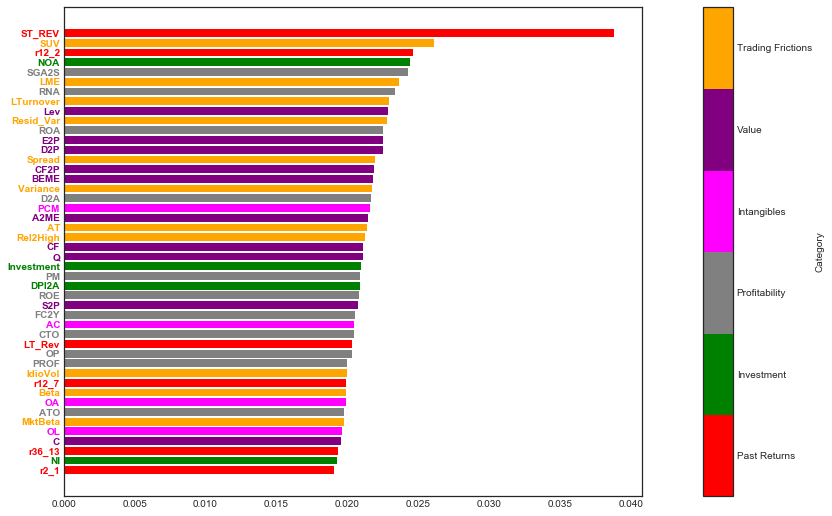

In [10]:
model_test.plotIndividualFeatureImportance(sess, dl_test, plotPath='model_char_shift/model_GAN/plot', initial_state=INITIAL_test, top=46, figsize=(12,9))

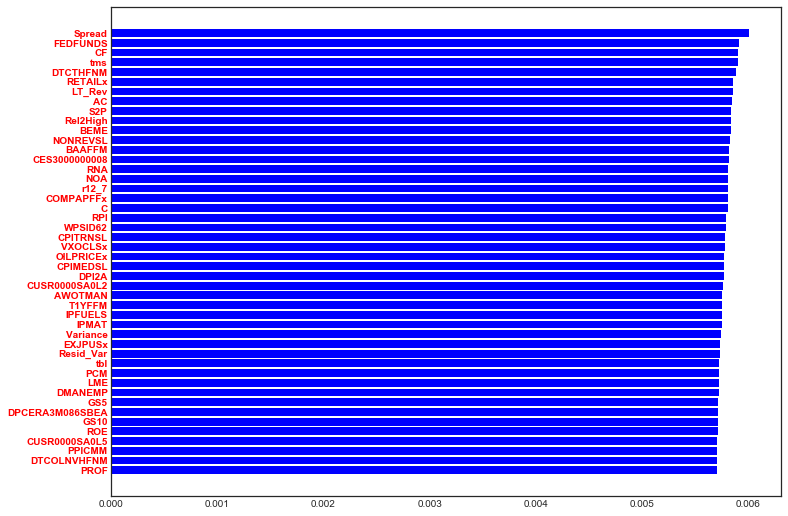

In [11]:
model_test.plotMacroFeatureImportance(sess, dl_test, plotPath='model_char_shift/model_GAN/plot', initial_state=INITIAL_test, top=46, figsize=(12,9))

##### Macro State Process

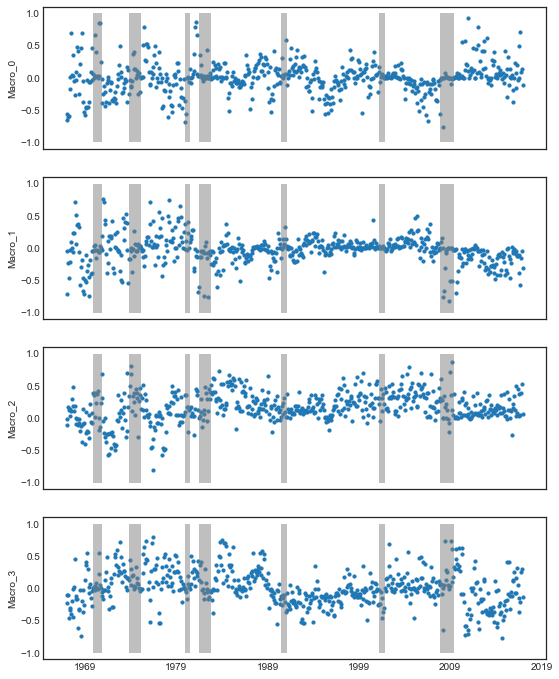

In [12]:
SMV = np.load('model_char_shift/model_GAN/4/SMV.npy')
plot_SMV(SMV, plotPath='model_char_shift/model_GAN/plot')

##### Model Performance

In [13]:
w = model.getWeightWithData(sess, dl, initial_state=INITIAL_train, normalized=True)
w_valid = model_valid.getWeightWithData(sess, dl_valid, initial_state=INITIAL_valid, normalized=True)
w_test = model_test.getWeightWithData(sess, dl_test, initial_state=INITIAL_test, normalized=True)

INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:

In [14]:
Ftrain = model.getNormalizedSDFFactor(sess, dl, initial_state=INITIAL_train)
Fvalid = model_valid.getNormalizedSDFFactor(sess, dl_valid, initial_state=INITIAL_valid)
Ftest = model_test.getNormalizedSDFFactor(sess, dl_test, initial_state=INITIAL_test)
# np.savez('model_char_shift/model_GAN/SDF_normalized.npz', train=Ftrain, valid=Fvalid, test=Ftest)

INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:

In [15]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))
loss_train = max_1_month_loss(Ftrain / Ftrain.std())
loss_valid = max_1_month_loss(Fvalid / Fvalid.std())
loss_test = max_1_month_loss(Ftest / Ftest.std())
deco_print('Max 1 Month Loss: Train %0.2f\tValid %0.2f\tTest %0.2f' %(loss_train, loss_valid, loss_test))
drawdown_train = max_drawdown(Ftrain)
drawdown_valid = max_drawdown(Fvalid)
drawdown_test = max_drawdown(Ftest)
deco_print('Max Drawdown: Train %d\tValid %d\tTest %d' %(drawdown_train, drawdown_valid, drawdown_test))

>==================> SDF Portfolio Sharpe Ratio: Train 2.68	Valid 1.43	Test 0.75
>==================> Max 1 Month Loss: Train 0.38	Valid -0.28	Test -5.76
>==================> Max Drawdown: Train 0	Valid 1	Test 5


In [16]:
Ftrain = model.getSDFFactor(sess, dl, initial_state=INITIAL_train)
Fvalid = model_valid.getSDFFactor(sess, dl_valid, initial_state=INITIAL_valid)
Ftest = model_test.getSDFFactor(sess, dl_test, initial_state=INITIAL_test)
# np.savez('model_char_shift/model_GAN/SDF.npz', train=Ftrain, valid=Fvalid, test=Ftest)

INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:

In [17]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))
loss_train = max_1_month_loss(Ftrain / Ftrain.std())
loss_valid = max_1_month_loss(Fvalid / Fvalid.std())
loss_test = max_1_month_loss(Ftest / Ftest.std())
deco_print('Max 1 Month Loss: Train %0.2f\tValid %0.2f\tTest %0.2f' %(loss_train, loss_valid, loss_test))
drawdown_train = max_drawdown(Ftrain)
drawdown_valid = max_drawdown(Fvalid)
drawdown_test = max_drawdown(Ftest)
deco_print('Max Drawdown: Train %d\tValid %d\tTest %d' %(drawdown_train, drawdown_valid, drawdown_test))

>==================> SDF Portfolio Sharpe Ratio: Train 3.21	Valid 1.45	Test 0.72
>==================> Max 1 Month Loss: Train 0.18	Valid -0.27	Test -5.95
>==================> Max Drawdown: Train 0	Valid 1	Test 5


In [18]:
### Large Cap
Ftrain = getFactorWithLargeCap(-w, dl, mask_train, normalized=True, norm='l1')
Fvalid = getFactorWithLargeCap(-w_valid, dl_valid, mask_valid, normalized=True, norm='l1')
Ftest = getFactorWithLargeCap(-w_test, dl_test, mask_test, normalized=True, norm='l1')

In [19]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))
loss_train = max_1_month_loss(Ftrain / Ftrain.std())
loss_valid = max_1_month_loss(Fvalid / Fvalid.std())
loss_test = max_1_month_loss(Ftest / Ftest.std())
deco_print('Max 1 Month Loss: Train %0.2f\tValid %0.2f\tTest %0.2f' %(loss_train, loss_valid, loss_test))
drawdown_train = max_drawdown(Ftrain)
drawdown_valid = max_drawdown(Fvalid)
drawdown_test = max_drawdown(Ftest)
deco_print('Max Drawdown: Train %d\tValid %d\tTest %d' %(drawdown_train, drawdown_valid, drawdown_test))

>==================> SDF Portfolio Sharpe Ratio: Train 0.97	Valid 0.54	Test 0.26
>==================> Max 1 Month Loss: Train -6.91	Valid -1.36	Test -5.01
>==================> Max Drawdown: Train 2	Valid 2	Test 7


In [20]:
### Large Cap 0.001%
Ftrain = getFactorWithLargeCap(-w, dl, mask_train_0001, normalized=True, norm='l1')
Fvalid = getFactorWithLargeCap(-w_valid, dl_valid, mask_valid_0001, normalized=True, norm='l1')
Ftest = getFactorWithLargeCap(-w_test, dl_test, mask_test_0001, normalized=True, norm='l1')

In [21]:
SR_train = sharpe(Ftrain)
SR_valid = sharpe(Fvalid)
SR_test = sharpe(Ftest)
deco_print('SDF Portfolio Sharpe Ratio: Train %0.2f\tValid %0.2f\tTest %0.2f' %(SR_train, SR_valid, SR_test))
loss_train = max_1_month_loss(Ftrain / Ftrain.std())
loss_valid = max_1_month_loss(Fvalid / Fvalid.std())
loss_test = max_1_month_loss(Ftest / Ftest.std())
deco_print('Max 1 Month Loss: Train %0.2f\tValid %0.2f\tTest %0.2f' %(loss_train, loss_valid, loss_test))
drawdown_train = max_drawdown(Ftrain)
drawdown_valid = max_drawdown(Fvalid)
drawdown_test = max_drawdown(Ftest)
deco_print('Max Drawdown: Train %d\tValid %d\tTest %d' %(drawdown_train, drawdown_valid, drawdown_test))

>==================> SDF Portfolio Sharpe Ratio: Train 2.32	Valid 1.09	Test 0.41
>==================> Max 1 Month Loss: Train -1.17	Valid -1.14	Test -4.84
>==================> Max Drawdown: Train 1	Valid 1	Test 5


In [27]:
# EV, XS-R2
EV_train, XSR2_train, WXSR2_train = calculateStatistics(beta_train, dl)
EV_valid, XSR2_valid, WXSR2_valid = calculateStatistics(beta_valid, dl_valid)
EV_test, XSR2_test, WXSR2_test = calculateStatistics(beta_test, dl_test)

In [28]:
deco_print('Explained Variation: Train %0.2f\tValid %0.2f\tTest %0.2f' %(EV_train, EV_valid, EV_test))
deco_print('XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(XSR2_train, XSR2_valid, XSR2_test))
deco_print('(Weighted) XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(WXSR2_train, WXSR2_valid, WXSR2_test))

>==================> Explained Variation: Train 0.20	Valid 0.09	Test 0.08
>==================> XS-R2: Train -0.04	Valid 0.04	Test 0.04
>==================> (Weighted) XS-R2: Train 0.12	Valid 0.01	Test 0.23


In [29]:
### Large Cap
EV_train, XSR2_train, WXSR2_train = calculateStatistics(beta_train, dl, mask_train)
EV_valid, XSR2_valid, WXSR2_valid = calculateStatistics(beta_valid, dl_valid, mask_valid)
EV_test, XSR2_test, WXSR2_test = calculateStatistics(beta_test, dl_test, mask_test)

In [30]:
deco_print('Explained Variation: Train %0.2f\tValid %0.2f\tTest %0.2f' %(EV_train, EV_valid, EV_test))
deco_print('XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(XSR2_train, XSR2_valid, XSR2_test))
deco_print('(Weighted) XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(WXSR2_train, WXSR2_valid, WXSR2_test))

>==================> Explained Variation: Train 0.28	Valid 0.34	Test 0.18
>==================> XS-R2: Train 0.07	Valid 0.13	Test 0.06
>==================> (Weighted) XS-R2: Train 0.27	Valid 0.23	Test 0.32


In [31]:
### Large Cap 0.001%
EV_train, XSR2_train, WXSR2_train = calculateStatistics(beta_train, dl, mask_train_0001)
EV_valid, XSR2_valid, WXSR2_valid = calculateStatistics(beta_valid, dl_valid, mask_valid_0001)
EV_test, XSR2_test, WXSR2_test = calculateStatistics(beta_test, dl_test, mask_test_0001)

In [32]:
deco_print('Explained Variation: Train %0.2f\tValid %0.2f\tTest %0.2f' %(EV_train, EV_valid, EV_test))
deco_print('XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(XSR2_train, XSR2_valid, XSR2_test))
deco_print('(Weighted) XS-R2: Train %0.2f\tValid %0.2f\tTest %0.2f' %(WXSR2_train, WXSR2_valid, WXSR2_test))

>==================> Explained Variation: Train 0.23	Valid 0.22	Test 0.14
>==================> XS-R2: Train 0.04	Valid 0.12	Test -0.00
>==================> (Weighted) XS-R2: Train 0.20	Valid 0.13	Test 0.26


In [33]:
### Turnover
_, _, T_train_plus_mean, T_train_minus_mean = calculateTurnover_with_dl(dl, -w, rf_train)
_, _, T_valid_plus_mean, T_valid_minus_mean = calculateTurnover_with_dl(dl_valid, -w_valid, rf_valid)
_, _, T_test_plus_mean, T_test_minus_mean = calculateTurnover_with_dl(dl_test, -w_test, rf_test)

In [34]:
deco_print('Turnover (Long): Train %0.2f\tValid %0.2f\tTest %0.2f' %(T_train_plus_mean, T_valid_plus_mean, T_test_plus_mean))
deco_print('Turnover (Short): Train %0.2f\tValid %0.2f\tTest %0.2f' %(T_train_minus_mean, T_valid_minus_mean, T_test_minus_mean))

>==================> Turnover (Long): Train 0.47	Valid 0.40	Test 0.40
>==================> Turnover (Short): Train 1.05	Valid 1.04	Test 1.02


##### Performance of Extreme Portfolio

In [7]:
deciles = [0.01, 0.05, 0.1, 0.25, 0.5]
SR = pd.DataFrame(np.zeros((len(deciles), 3)), index=deciles, columns=['train','valid','test'])
SR_value = pd.DataFrame(np.zeros((len(deciles), 3)), index=deciles, columns=['train','valid','test'])

In [8]:
for decile in deciles:
    SR.loc[decile, 'train'] = eval_RtnFcst(model_plot_RF, sess, dl_RF_train, quantile=decile)[1]
    SR.loc[decile, 'valid'] = eval_RtnFcst(model_plot_RF, sess, dl_RF_valid, quantile=decile)[1]
    SR.loc[decile, 'test'] = eval_RtnFcst(model_plot_RF, sess, dl_RF_test, quantile=decile)[1]
for decile in deciles:
    SR_value.loc[decile, 'train'] = eval_RtnFcst(model_plot_RF, sess, dl_RF_train, value=value, quantile=decile)[1]
    SR_value.loc[decile, 'valid'] = eval_RtnFcst(model_plot_RF, sess, dl_RF_valid, value=value_valid, quantile=decile)[1]
    SR_value.loc[decile, 'test'] = eval_RtnFcst(model_plot_RF, sess, dl_RF_test, value=value_test, quantile=decile)[1]

INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from

INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/9/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from

INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/9/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from

INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from

INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/9/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from

In [9]:
SR

,train,valid,test
0.01,1.135911,0.591520,0.524199
0.05,1.130473,1.201378,0.684209
0.10,1.020629,1.229314,0.613818
0.25,0.971881,1.209865,0.580315
0.50,0.943000,1.146694,0.546381


In [10]:
SR_value

,train,valid,test
0.01,0.845565,0.439122,0.328434
0.05,0.675191,0.473635,0.424064
0.10,0.538629,0.439842,0.355067
0.25,0.499210,0.103518,0.261861
0.50,0.358931,0.246714,0.176904


##### Model Comparison

In [35]:
models = ['GAN (hidden state)', 'UNC', 'GAN (no macro)', 'FFN (no macro)', 'EN (no macro)', 'LS (no macro)', 'GAN (all macro)', 'FFN (all macro)', 'EN (all macro)', 'LS (all macro)']
SR = [[2.68, 1.43, 0.75],
     [1.93, 1.33, 0.53],
     [1.90, 1.35, 0.69],
     [0.45, 0.42, 0.44],
     [1.37, 1.15, 0.50],
     [1.80, 0.58, 0.42],
     [1.07, 0.05, 0.05],
     [1.46, 0.46, 0.21],
     [1.95, 0.54, 0.19],
     [2.63, 0.34, 0.10]]
df_SR = pd.DataFrame(SR, columns=['Training', 'Validation', 'Test'], index=models)
color_models = ['brown'] + ['red'] + ['orange'] * 4 + ['yellow'] * 4

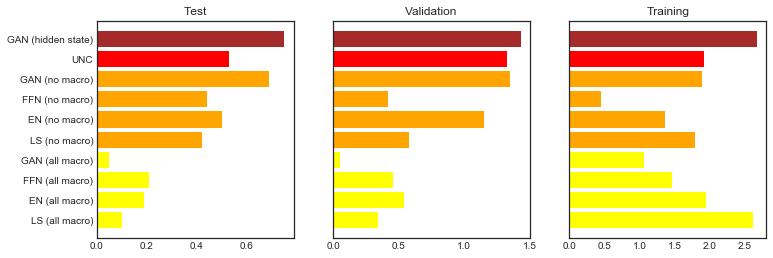

In [36]:
y_pos = np.arange(len(models))
fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot(131)
ax1.barh(y_pos, df_SR.loc[:,'Test'].values, align='center', color=color_models)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(models)
ax1.invert_yaxis()
ax1.set_title('Test')

ax2 = plt.subplot(132)
ax2.barh(y_pos, df_SR.loc[:,'Validation'].values, align='center', color=color_models)
ax2.invert_yaxis()
ax2.set_yticks([])
ax2.set_title('Validation')

ax3 = plt.subplot(133)
ax3.barh(y_pos, df_SR.loc[:,'Training'].values, align='center', color=color_models)
ax3.invert_yaxis()
ax3.set_yticks([])
ax3.set_title('Training')
plt.show()

##### Predictive Performance

In [24]:
tf.reset_default_graph()
global_step = tf.train.get_or_create_global_step()
model_plot_RF = FeedForwardModelWithNA_Return_Ensembled(logdirs_RF, config_RF, 'plot', global_step=global_step)
gpu_options = tf.GPUOptions(allow_growth=True)
sess_config = tf.ConfigProto(gpu_options=gpu_options)
sess = tf.Session(config=sess_config)

In [25]:
dl_RF_train = data_layer.DataInRamInputLayer(config['individual_feature_file'])
dl_RF_valid = data_layer.DataInRamInputLayer(config['individual_feature_file_valid'])
dl_RF_test = data_layer.DataInRamInputLayer(config['individual_feature_file_test'])

In [26]:
beta_train = model_plot_RF.getPrediction(sess, dl_RF_train)
beta_valid = model_plot_RF.getPrediction(sess, dl_RF_valid)
beta_test = model_plot_RF.getPrediction(sess, dl_RF_test)
# np.savez('model_char_shift/model_GAN_RF_normalized/forecasts.npz', train=beta_train, valid=beta_valid, test=beta_test)

INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from

In [37]:
decile = 10
for _, (I_macro, I, R, mask) in enumerate(dl.iterateOneEpoch(subEpoch=False)):
    portfolios_train = construct_decile_portfolios(beta_train, R, mask, decile=decile)
for _, (I_macro, I, R, mask) in enumerate(dl_valid.iterateOneEpoch(subEpoch=False)):
    portfolios_valid = construct_decile_portfolios(beta_valid, R, mask, decile=decile)
for _, (I_macro, I, R, mask) in enumerate(dl_test.iterateOneEpoch(subEpoch=False)):
    portfolios_test = construct_decile_portfolios(beta_test, R, mask, decile=decile)
df = pd.DataFrame(np.concatenate([portfolios_train, portfolios_valid, portfolios_test]), columns=['decile %d' %(k+1) for k in range(decile)])
# np.save('model_char_shift/model_GAN/decile_portfolios.npy', df.values)

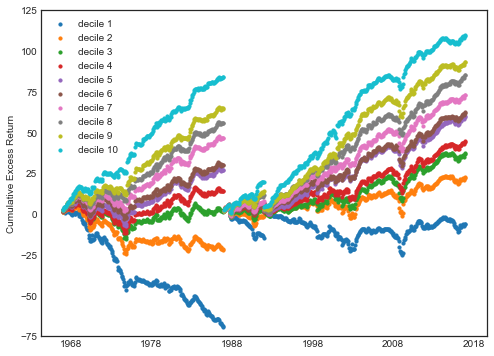

In [38]:
plot_decile_portfolios(df, plotPath='model_char_shift/model_GAN/plot')

In [39]:
decile = 10
for _, (I_macro, I, R, mask) in enumerate(dl.iterateOneEpoch(subEpoch=False)):
    portfolios_train = construct_decile_portfolios(beta_train, R, mask, value=value, decile=decile)
for _, (I_macro, I, R, mask) in enumerate(dl_valid.iterateOneEpoch(subEpoch=False)):
    portfolios_valid = construct_decile_portfolios(beta_valid, R, mask, value=value_valid, decile=decile)
for _, (I_macro, I, R, mask) in enumerate(dl_test.iterateOneEpoch(subEpoch=False)):
    portfolios_test = construct_decile_portfolios(beta_test, R, mask, value=value_test, decile=decile)
df = pd.DataFrame(np.concatenate([portfolios_train, portfolios_valid, portfolios_test]), columns=['decile %d' %(k+1) for k in range(decile)])

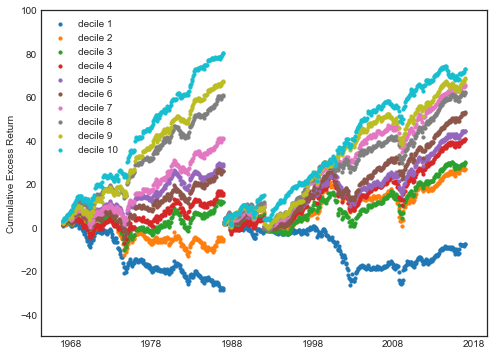

In [15]:
plot_decile_portfolios(df, plotPath='model_char_shift/model_GAN/plot')

>==================> Plotting Variable: A2ME	Elapse / Estimate: 1.40s / 64.33s
>==================> Plotting Variable: AC	Elapse / Estimate: 3.43s / 78.82s
>==================> Plotting Variable: AT	Elapse / Estimate: 5.77s / 88.51s
>==================> Plotting Variable: ATO	Elapse / Estimate: 7.14s / 82.15s
>==================> Plotting Variable: BEME	Elapse / Estimate: 8.61s / 79.25s
>==================> Plotting Variable: Beta	Elapse / Estimate: 10.03s / 76.90s
>==================> Plotting Variable: C	Elapse / Estimate: 11.51s / 75.62s
>==================> Plotting Variable: CF	Elapse / Estimate: 12.91s / 74.21s
>==================> Plotting Variable: CF2P	Elapse / Estimate: 15.39s / 78.64s
>==================> Plotting Variable: CTO	Elapse / Estimate: 18.10s / 83.28s
>==================> Plotting Variable: D2A	Elapse / Estimate: 20.12s / 84.13s
>==================> Plotting Variable: D2P	Elapse / Estimate: 22.82s / 87.47s
>==================> Plotting Variable: DPI2A	Elapse / Est

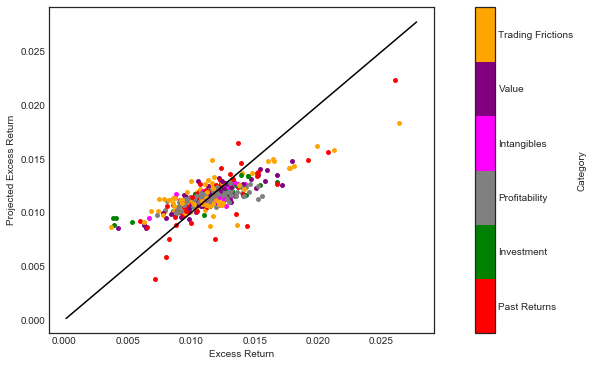

In [10]:
plotReturnDecile(dl_test, beta_test, plotPath='model_char_shift/model_GAN/plot')

>==================> Plotting Variable: A2ME	Elapse / Estimate: 1.51s / 69.67s
>==================> Plotting Variable: AC	Elapse / Estimate: 2.94s / 67.54s
>==================> Plotting Variable: AT	Elapse / Estimate: 4.38s / 67.14s
>==================> Plotting Variable: ATO	Elapse / Estimate: 5.95s / 68.42s
>==================> Plotting Variable: BEME	Elapse / Estimate: 7.45s / 68.58s
>==================> Plotting Variable: Beta	Elapse / Estimate: 8.97s / 68.75s
>==================> Plotting Variable: C	Elapse / Estimate: 10.43s / 68.52s
>==================> Plotting Variable: CF	Elapse / Estimate: 11.86s / 68.17s
>==================> Plotting Variable: CF2P	Elapse / Estimate: 13.36s / 68.30s
>==================> Plotting Variable: CTO	Elapse / Estimate: 14.80s / 68.09s
>==================> Plotting Variable: D2A	Elapse / Estimate: 16.25s / 67.95s
>==================> Plotting Variable: D2P	Elapse / Estimate: 17.62s / 67.54s
>==================> Plotting Variable: DPI2A	Elapse / Esti

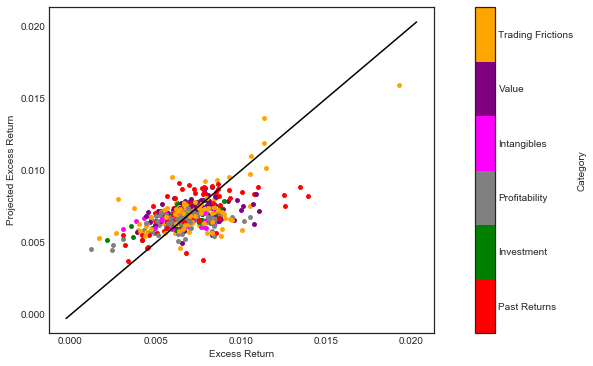

In [9]:
plotReturnDecile(dl_test, beta_test, value=value_test, plotPath='model_char_shift/model_GAN/plot')

##### Time Series Pricing Error

In [22]:
df5 = load_dataframe('datasets/F-F_Research_Data_5_Factors_2x3.CSV', skiprows=2, nrows=659)
df_FF = df5.loc[196701:201612].copy()
df_FF.drop(['RF'], inplace=True, axis=1)

In [44]:
# vList = ['Mkt-RF']
# vList = ['Mkt-RF', 'SMB', 'HML']
vList = ['Mkt-RF', 'SMB', 'HML','RMW','CMA']

In [45]:
s = ''
for i in range(1,11):
    alpha, t, _ = OLS(df_FF.loc[:,vList].values, df.loc[:,'decile %d'%i].values*12, alpha=True)
    alpha_test, t_test, _ = OLS(df_FF.loc[:,vList].values[300:], df.loc[:,'decile %d'%i].values[300:]*12, alpha=True)
    s += '%0.2f & %0.2f & %0.2f & %0.2f \n' %(alpha, t, alpha_test, t_test)
alpha, t, _ = OLS(df_FF.loc[:,vList].values, df.loc[:,'decile 10'].values*12 - df.loc[:,'decile 1'].values*12, alpha=True)
alpha_test, t_test, _ = OLS(df_FF.loc[:,vList].values[300:], df.loc[:,'decile 10'].values[300:]*12 - df.loc[:,'decile 1'].values[300:]*12, alpha=True)
s += '%0.2f & %0.2f & %0.2f & %0.2f \n' %(alpha, t, alpha_test, t_test)
print(s)

-0.20 & -11.99 & -0.12 & -4.35 
-0.09 & -8.29 & -0.05 & -2.68 
-0.04 & -4.87 & -0.01 & -1.05 
-0.02 & -2.86 & -0.01 & -0.54 
0.01 & 1.36 & 0.03 & 2.17 
0.01 & 1.51 & 0.02 & 2.20 
0.04 & 5.16 & 0.04 & 3.41 
0.07 & 8.05 & 0.07 & 4.86 
0.11 & 8.58 & 0.11 & 5.39 
0.25 & 10.43 & 0.27 & 6.59 
0.46 & 18.13 & 0.39 & 9.96 



In [46]:
s, p = GRS(df_FF.loc[:,vList].values, df.values)
s_test, p_test = GRS(df_FF.loc[:,vList].values[300:], df.values[300:])
print('%0.2f & %0.2f & %0.2f & %0.2f \n' %(s, p, s_test, p_test))

37.64 & 0.00 & 10.75 & 0.00 



##### Performance on Portfolios

In [7]:
tmp = np.load('model_char_shift/model_FFN/forecasts.npz')
beta_FFN_train = tmp['train']
beta_FFN_valid = tmp['valid']
beta_FFN_test = tmp['test']

tmp = np.load('model_char_shift/model_GAN_RF_normalized/forecasts.npz')
beta_GAN_train = tmp['train']
beta_GAN_valid = tmp['valid']
beta_GAN_test = tmp['test']

tmp = np.load('model_char_shift/model_Linear_LS/ElasticNet/forecasts.npz')
beta_EN_train = tmp['train']
beta_EN_valid = tmp['valid']
beta_EN_test = tmp['test']

##### Decile Sorted Portfolios

In [6]:
def printTable(EV_EN, EV_FFN, EV_GAN, R2_EN, R2_FFN, R2_GAN):
    s = ''
    for i in range(10):
        s += '%d & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f \\\\\n' %(i+1, EV_EN[i], EV_FFN[i], EV_GAN[i], R2_EN[i], R2_FFN[i], R2_GAN[i])
    return s

In [14]:
### Equally Weighted
charName = 'ST_REV'
UV_EN_all, Alpha_EN_all, R2_EN_all, UV_EN, Alpha_EN, R2_EN = calculateStatisticsDecile(dl_test, beta_EN_test, charName=charName)
UV_FFN_all, Alpha_FFN_all, R2_FFN_all, UV_FFN, Alpha_FFN, R2_FFN = calculateStatisticsDecile(dl_test, beta_FFN_test, charName=charName)
UV_GAN_all, Alpha_GAN_all, R2_GAN_all, UV_GAN, Alpha_GAN, R2_GAN = calculateStatisticsDecile(dl_test, beta_GAN_test, charName=charName)
print('EV & XS-R2\n'+printTable(1-UV_EN, 1-UV_FFN, 1-UV_GAN, R2_EN, R2_FFN, R2_GAN)+'All & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f \\\\' %(1-UV_EN_all, 1-UV_FFN_all, 1-UV_GAN_all, R2_EN_all, R2_FFN_all, R2_GAN_all))
print('\nEV & Alpha\n'+printTable(1-UV_EN, 1-UV_FFN, 1-UV_GAN, Alpha_EN, Alpha_FFN, Alpha_GAN)+'All & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f \\\\' %(1-UV_EN_all, 1-UV_FFN_all, 1-UV_GAN_all, Alpha_EN_all, Alpha_FFN_all, Alpha_GAN_all))

EV & XS-R2
1 & 0.92 & 0.93 & 0.92 & 0.95 & 0.99 & 0.98 \\
2 & 0.97 & 0.96 & 0.96 & 0.93 & 0.98 & 0.96 \\
3 & 0.96 & 0.94 & 0.96 & 0.97 & 1.00 & 0.98 \\
4 & 0.92 & 0.90 & 0.94 & 0.99 & 1.00 & 0.96 \\
5 & 0.86 & 0.84 & 0.92 & 0.98 & 0.97 & 0.98 \\
6 & 0.72 & 0.74 & 0.92 & 0.82 & 0.87 & 1.00 \\
7 & 0.46 & 0.58 & 0.89 & 0.53 & 0.70 & 1.00 \\
8 & 0.12 & 0.33 & 0.82 & 0.07 & 0.39 & 0.99 \\
9 & -0.26 & -0.06 & 0.66 & -0.66 & -0.35 & 0.93 \\
10 & -0.38 & -0.53 & 0.33 & -1.40 & -2.35 & 0.79 \\
All & 0.57 & 0.59 & 0.82 & 0.75 & 0.78 & 0.97 \\

EV & Alpha
1 & 0.92 & 0.93 & 0.92 & 0.15 & 0.07 & 0.09 \\
2 & 0.97 & 0.96 & 0.96 & -0.09 & -0.05 & -0.07 \\
3 & 0.96 & 0.94 & 0.96 & -0.05 & -0.01 & -0.05 \\
4 & 0.92 & 0.90 & 0.94 & -0.02 & 0.01 & -0.05 \\
5 & 0.86 & 0.84 & 0.92 & 0.04 & 0.05 & -0.03 \\
6 & 0.72 & 0.74 & 0.92 & 0.10 & 0.09 & -0.01 \\
7 & 0.46 & 0.58 & 0.89 & 0.15 & 0.12 & -0.00 \\
8 & 0.12 & 0.33 & 0.82 & 0.20 & 0.16 & 0.02 \\
9 & -0.26 & -0.06 & 0.66 & 0.26 & 0.23 & 0.05 \\
10 & -0.38 & 

In [9]:
charRank = model_test._variable_rank
s = ''
for charName in charRank:
    deco_print('Processing %s          ' %charName, '\r')
    UV_EN_all, _, R2_EN_all, _, _, _ = calculateStatisticsDecile(dl_test, beta_EN_test, charName=charName)
    UV_FFN_all, _, R2_FFN_all, _, _, _ = calculateStatisticsDecile(dl_test, beta_FFN_test, charName=charName)
    UV_GAN_all, _, R2_GAN_all, _, _, _ = calculateStatisticsDecile(dl_test, beta_GAN_test, charName=charName)
    s += '%s & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f \\\\\n' %(charName, 1-UV_EN_all, 1-UV_FFN_all, 1-UV_GAN_all, R2_EN_all, R2_FFN_all, R2_GAN_all)
print(s)

In [21]:
### Value Weighted
charName = 'ST_REV'
UV_EN_all, Alpha_EN_all, R2_EN_all, UV_EN, Alpha_EN, R2_EN = calculateStatisticsDecile(dl_test, beta_EN_test, charName=charName, value=value_test)
UV_FFN_all, Alpha_FFN_all, R2_FFN_all, UV_FFN, Alpha_FFN, R2_FFN = calculateStatisticsDecile(dl_test, beta_FFN_test, charName=charName, value=value_test)
UV_GAN_all, Alpha_GAN_all, R2_GAN_all, UV_GAN, Alpha_GAN, R2_GAN = calculateStatisticsDecile(dl_test, beta_GAN_test, charName=charName, value=value_test)
print('EV & XS-R2\n'+printTable(1-UV_EN, 1-UV_FFN, 1-UV_GAN, R2_EN, R2_FFN, R2_GAN)+'All & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f \\\\' %(1-UV_EN_all, 1-UV_FFN_all, 1-UV_GAN_all, R2_EN_all, R2_FFN_all, R2_GAN_all))
print('\nEV & Alpha\n'+printTable(1-UV_EN, 1-UV_FFN, 1-UV_GAN, Alpha_EN, Alpha_FFN, Alpha_GAN)+'All & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f \\\\' %(1-UV_EN_all, 1-UV_FFN_all, 1-UV_GAN_all, Alpha_EN_all, Alpha_FFN_all, Alpha_GAN_all))

EV & XS-R2
1 & 0.84 & 0.74 & 0.77 & 0.61 & 0.48 & 0.81 \\
2 & 0.86 & 0.81 & 0.82 & 1.00 & 0.98 & 1.00 \\
3 & 0.80 & 0.82 & 0.84 & 0.91 & 0.99 & 0.98 \\
4 & 0.69 & 0.80 & 0.82 & 0.83 & 1.00 & 0.99 \\
5 & 0.58 & 0.68 & 0.71 & 0.79 & 0.99 & 0.97 \\
6 & 0.43 & 0.66 & 0.75 & 0.47 & 0.98 & 1.00 \\
7 & 0.23 & 0.64 & 0.77 & 0.38 & 0.99 & 1.00 \\
8 & -0.07 & 0.49 & 0.67 & -0.46 & 0.97 & 0.94 \\
9 & -0.25 & 0.29 & 0.58 & -1.15 & 0.80 & 1.00 \\
10 & -0.24 & -0.04 & 0.35 & -0.79 & -0.18 & 0.74 \\
All & 0.43 & 0.58 & 0.70 & 0.45 & 0.79 & 0.94 \\

EV & Alpha
1 & 0.84 & 0.74 & 0.77 & -0.18 & -0.21 & -0.13 \\
2 & 0.86 & 0.81 & 0.82 & 0.00 & -0.05 & 0.00 \\
3 & 0.80 & 0.82 & 0.84 & 0.13 & 0.04 & 0.06 \\
4 & 0.69 & 0.80 & 0.82 & 0.16 & 0.03 & 0.03 \\
5 & 0.58 & 0.68 & 0.71 & 0.13 & -0.03 & -0.04 \\
6 & 0.43 & 0.66 & 0.75 & 0.22 & 0.05 & 0.01 \\
7 & 0.23 & 0.64 & 0.77 & 0.20 & 0.03 & -0.02 \\
8 & -0.07 & 0.49 & 0.67 & 0.23 & 0.03 & -0.05 \\
9 & -0.25 & 0.29 & 0.58 & 0.30 & 0.09 & -0.01 \\
10 & -0.24 & -0

In [13]:
charRank = model_test._variable_rank
s = ''
for charName in charRank:
    deco_print('Processing %s          ' %charName, '\r')
    UV_EN_all, _, R2_EN_all, _, _, _ = calculateStatisticsDecile(dl_test, beta_EN_test, charName=charName, value=value_test)
    UV_FFN_all, _, R2_FFN_all, _, _, _ = calculateStatisticsDecile(dl_test, beta_FFN_test, charName=charName, value=value_test)
    UV_GAN_all, _, R2_GAN_all, _, _, _ = calculateStatisticsDecile(dl_test, beta_GAN_test, charName=charName, value=value_test)
    s += '%s & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f \\\\\n' %(charName, 1-UV_EN_all, 1-UV_FFN_all, 1-UV_GAN_all, R2_EN_all, R2_FFN_all, R2_GAN_all)
print(s)

ST_REV & 0.43 & 0.58 & 0.70 & 0.45 & 0.79 & 0.94 \\ 
SUV & 0.42 & 0.75 & 0.83 & 0.64 & 0.97 & 0.99 \\
r12_2 & 0.26 & 0.27 & 0.54 & 0.66 & 0.71 & 0.93 \\
NOA & 0.58 & 0.69 & 0.78 & 0.94 & 0.96 & 0.95 \\
SGA2S & 0.52 & 0.63 & 0.73 & 0.93 & 0.95 & 0.96 \\
LME & 0.83 & 0.78 & 0.86 & 0.96 & 0.95 & 0.97 \\
RNA & 0.50 & 0.48 & 0.69 & 0.93 & 0.87 & 0.96 \\
LTurnover & 0.52 & 0.57 & 0.68 & 0.88 & 0.89 & 0.96 \\
Lev & 0.52 & 0.63 & 0.73 & 0.90 & 0.92 & 0.95 \\
Resid_Var & 0.52 & 0.27 & 0.65 & 0.84 & 0.73 & 0.97 \\
ROA & 0.51 & 0.44 & 0.70 & 0.92 & 0.93 & 0.98 \\
E2P & 0.48 & 0.44 & 0.67 & 0.86 & 0.80 & 0.95 \\
D2P & 0.47 & 0.51 & 0.72 & 0.82 & 0.85 & 0.94 \\
Spread & 0.49 & 0.32 & 0.60 & 0.76 & 0.71 & 0.92 \\
CF2P & 0.46 & 0.47 & 0.66 & 0.90 & 0.89 & 0.99 \\
BEME & 0.70 & 0.75 & 0.82 & 0.97 & 0.94 & 0.98 \\
Variance & 0.48 & 0.27 & 0.61 & 0.74 & 0.72 & 0.89 \\
D2A & 0.57 & 0.71 & 0.78 & 0.96 & 0.96 & 0.97 \\
PCM & 0.66 & 0.79 & 0.82 & 0.97 & 0.98 & 0.99 \\
A2ME & 0.72 & 0.79 & 0.83 & 0.97 & 0.96

##### Double Sorted Portfolios

In [8]:
def printTable(EV_EN, EV_FFN, EV_GAN, R2_EN, R2_FFN, R2_GAN):
    s = ''
    for j in range(5):
        for k in range(5):
            i = j * 5 + k
            s += '%d & %d & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f \\\\\n' %(j+1, k+1, EV_EN[i], EV_FFN[i], EV_GAN[i], R2_EN[i], R2_FFN[i], R2_GAN[i])
    return s

In [24]:
### Equally Weighted
charName1 = 'ST_REV'
charName2 = 'r12_2'
UV_EN_all, Alpha_EN_all, R2_EN_all, UV_EN, Alpha_EN, R2_EN = calculateStatisticsDoubleSorted5(dl_test, beta_EN_test, charName1, charName2)
UV_FFN_all, Alpha_FFN_all, R2_FFN_all, UV_FFN, Alpha_FFN, R2_FFN = calculateStatisticsDoubleSorted5(dl_test, beta_FFN_test, charName1, charName2)
UV_GAN_all, Alpha_GAN_all, R2_GAN_all, UV_GAN, Alpha_GAN, R2_GAN = calculateStatisticsDoubleSorted5(dl_test, beta_GAN_test, charName1, charName2)
print('EV & XS-R2\n'+printTable(1-UV_EN, 1-UV_FFN, 1-UV_GAN, R2_EN, R2_FFN, R2_GAN)+'All & & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f \\\\' %(1-UV_EN_all, 1-UV_FFN_all, 1-UV_GAN_all, R2_EN_all, R2_FFN_all, R2_GAN_all))
print('\nEV & Alpha\n'+printTable(1-UV_EN, 1-UV_FFN, 1-UV_GAN, Alpha_EN, Alpha_FFN, Alpha_GAN)+'All & & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f \\\\' %(1-UV_EN_all, 1-UV_FFN_all, 1-UV_GAN_all, Alpha_EN_all, Alpha_FFN_all, Alpha_GAN_all))

EV & XS-R2
1 & 1 & 0.58 & 0.73 & 0.82 & 0.75 & 0.95 & 0.96 \\
1 & 2 & 0.84 & 0.85 & 0.87 & 0.99 & 1.00 & 0.99 \\
1 & 3 & 0.93 & 0.92 & 0.87 & 0.96 & 0.96 & 0.96 \\
1 & 4 & 0.89 & 0.90 & 0.86 & 0.96 & 0.99 & 0.99 \\
1 & 5 & 0.85 & 0.85 & 0.83 & 0.95 & 1.00 & 1.00 \\
2 & 1 & 0.44 & 0.46 & 0.73 & 0.81 & 0.87 & 1.00 \\
2 & 2 & 0.74 & 0.71 & 0.88 & 0.99 & 1.00 & 0.97 \\
2 & 3 & 0.88 & 0.85 & 0.85 & 0.99 & 1.00 & 0.96 \\
2 & 4 & 0.87 & 0.90 & 0.80 & 0.97 & 1.00 & 0.99 \\
2 & 5 & 0.82 & 0.81 & 0.81 & 0.96 & 1.00 & 0.99 \\
3 & 1 & 0.16 & 0.06 & 0.60 & 0.29 & 0.15 & 0.98 \\
3 & 2 & 0.48 & 0.51 & 0.83 & 0.78 & 0.92 & 0.95 \\
3 & 3 & 0.72 & 0.75 & 0.84 & 0.92 & 0.97 & 0.97 \\
3 & 4 & 0.83 & 0.83 & 0.80 & 0.97 & 0.99 & 0.99 \\
3 & 5 & 0.75 & 0.72 & 0.75 & 0.99 & 0.97 & 1.00 \\
4 & 1 & -0.29 & -0.56 & 0.33 & -1.24 & -2.54 & 0.84 \\
4 & 2 & -0.09 & 0.10 & 0.73 & -0.37 & 0.29 & 0.91 \\
4 & 3 & 0.28 & 0.53 & 0.82 & 0.39 & 0.85 & 0.98 \\
4 & 4 & 0.51 & 0.68 & 0.81 & 0.66 & 0.90 & 1.00 \\
4 & 5 & 0.48 &

In [26]:
### Value Weighted
charName1 = 'ST_REV'
charName2 = 'r12_2'
UV_EN_all, Alpha_EN_all, R2_EN_all, UV_EN, Alpha_EN, R2_EN = calculateStatisticsDoubleSorted5(dl_test, beta_EN_test, charName1, charName2, value=value_test)
UV_FFN_all, Alpha_FFN_all, R2_FFN_all, UV_FFN, Alpha_FFN, R2_FFN = calculateStatisticsDoubleSorted5(dl_test, beta_FFN_test, charName1, charName2, value=value_test)
UV_GAN_all, Alpha_GAN_all, R2_GAN_all, UV_GAN, Alpha_GAN, R2_GAN = calculateStatisticsDoubleSorted5(dl_test, beta_GAN_test, charName1, charName2, value=value_test)
print('EV & XS-R2\n'+printTable(1-UV_EN, 1-UV_FFN, 1-UV_GAN, R2_EN, R2_FFN, R2_GAN)+'All & & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f \\\\' %(1-UV_EN_all, 1-UV_FFN_all, 1-UV_GAN_all, R2_EN_all, R2_FFN_all, R2_GAN_all))
print('\nEV & Alpha\n'+printTable(1-UV_EN, 1-UV_FFN, 1-UV_GAN, Alpha_EN, Alpha_FFN, Alpha_GAN)+'All & & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f & %0.2f \\\\' %(1-UV_EN_all, 1-UV_FFN_all, 1-UV_GAN_all, Alpha_EN_all, Alpha_FFN_all, Alpha_GAN_all))

EV & XS-R2
1 & 1 & 0.35 & 0.32 & 0.62 & 0.77 & 0.85 & 0.94 \\
1 & 2 & 0.55 & 0.48 & 0.72 & 0.99 & 0.95 & 0.92 \\
1 & 3 & 0.66 & 0.61 & 0.74 & 0.92 & 0.87 & 0.94 \\
1 & 4 & 0.74 & 0.62 & 0.67 & 0.93 & 0.96 & 0.99 \\
1 & 5 & 0.69 & 0.58 & 0.58 & 0.81 & 0.94 & 0.98 \\
2 & 1 & 0.17 & 0.16 & 0.53 & 0.43 & 0.60 & 0.87 \\
2 & 2 & 0.32 & 0.39 & 0.67 & 0.60 & 0.85 & 0.92 \\
2 & 3 & 0.59 & 0.61 & 0.71 & 0.88 & 0.99 & 1.00 \\
2 & 4 & 0.72 & 0.74 & 0.59 & 1.00 & 0.98 & 0.99 \\
2 & 5 & 0.56 & 0.61 & 0.54 & 0.93 & 0.97 & 0.97 \\
3 & 1 & -0.02 & -0.01 & 0.48 & -1.08 & -0.69 & 0.99 \\
3 & 2 & 0.13 & 0.33 & 0.65 & 0.23 & 0.97 & 0.95 \\
3 & 3 & 0.41 & 0.62 & 0.66 & 0.53 & 0.98 & 1.00 \\
3 & 4 & 0.46 & 0.60 & 0.48 & 0.95 & 0.81 & 0.74 \\
3 & 5 & 0.39 & 0.53 & 0.42 & 0.83 & 1.00 & 0.99 \\
4 & 1 & -0.24 & -0.27 & 0.31 & -2.03 & -1.53 & 0.85 \\
4 & 2 & -0.24 & 0.15 & 0.58 & -1.95 & 0.65 & 0.74 \\
4 & 3 & 0.02 & 0.51 & 0.68 & -0.31 & 0.96 & 0.60 \\
4 & 4 & 0.19 & 0.53 & 0.51 & 0.39 & 0.99 & 0.92 \\
4 & 5 & 0

##### Relationship with Fama-French Factors

In [24]:
df5 = load_dataframe('datasets/F-F_Research_Data_5_Factors_2x3.CSV', skiprows=2, nrows=659)
df_test = df5.loc[199201:201612].copy()
df_test.loc[:,'Rsdf'] = Ftest[:,0] * 100
df_test.drop(['RF'], inplace=True, axis=1)
df_test.corr()

,Mkt-RF,SMB,HML,RMW,CMA,Rsdf
Mkt-RF,1.000000,0.200945,-0.150677,-0.478305,-0.342449,-0.095775
SMB,0.200945,1.000000,-0.131863,-0.481567,-0.026220,-0.087971
HML,-0.150677,-0.131863,1.000000,0.409205,0.647233,0.011501
RMW,-0.478305,-0.481567,0.409205,1.000000,0.264014,0.172972
CMA,-0.342449,-0.026220,0.647233,0.264014,1.000000,0.045875
Rsdf,-0.095775,-0.087971,0.011501,0.172972,0.045875,1.000000


In [25]:
y = df_test.loc[:,'Rsdf'].values
X = df_test.loc[:,['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].values

In [26]:
OLS(X,y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.246
Date:                Mon, 22 Apr 2019   Prob (F-statistic):             0.0499
Time:                        12:02:50   Log-Likelihood:                -432.18
No. Observations:                 300   AIC:                             876.4
Df Residuals:                     294   BIC:                             898.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0024      0.017      0.138      0.8

##### Correlation between SDF Factors

In [28]:
tmp = np.load('model_char_shift/model_Linear_LS/LS/SDF_normalized.npz')
SDF_LS_train = tmp['train'] / tmp['train'].std()
SDF_LS_valid = tmp['valid'] / tmp['valid'].std()
SDF_LS_test = tmp['test'] / tmp['test'].std()

tmp = np.load('model_char_shift/model_Linear_LS/ElasticNet/SDF_normalized.npz')
SDF_Elastic_train = tmp['train'] / tmp['train'].std()
SDF_Elastic_valid = tmp['valid'] / tmp['valid'].std()
SDF_Elastic_test = tmp['test'] / tmp['test'].std()

tmp = np.load('model_char_shift/model_FFN/SDF_normalized.npz')
SDF_FFN_train = tmp['train'] / tmp['train'].std()
SDF_FFN_valid = tmp['valid'] / tmp['valid'].std()
SDF_FFN_test = tmp['test'] / tmp['test'].std()

tmp = np.load('model_char_shift/model_GAN/SDF_normalized.npz')
SDF_GAN_train = tmp['train'] / tmp['train'].std()
SDF_GAN_valid = tmp['valid'] / tmp['valid'].std()
SDF_GAN_test = tmp['test'] / tmp['test'].std()

df = pd.DataFrame({'LS':np.concatenate([SDF_LS_train, SDF_LS_valid, SDF_LS_test]),
                    'EN':np.concatenate([SDF_Elastic_train, SDF_Elastic_valid, SDF_Elastic_test]),
                    'FFN':np.concatenate([SDF_FFN_train, SDF_FFN_valid, SDF_FFN_test]),
                    'GAN':np.concatenate([SDF_GAN_train, SDF_GAN_valid, SDF_GAN_test])[:,0]})

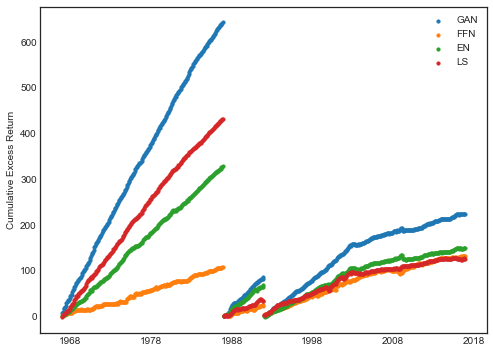

In [36]:
plot_SDF(df, columns=['GAN','FFN','EN','LS'], plotPath='model_char_shift/model_GAN/plot')

In [37]:
def corr_heat_map(df, plotPath=None):
    corr = df.corr()
    mask = np.ones_like(corr)
    mask[np.triu_indices_from(mask)] = False
    with sns.axes_style("white"):
        x = sns.heatmap(corr, mask=mask.T, square=True, 
            xticklabels=corr.columns, yticklabels=corr.columns, 
            annot=True, fmt="0.2f", linewidths=.5, cmap="YlGnBu")
    if plotPath is not None:
        plt.savefig(os.path.join(plotPath, 'corr.pdf'))
        plt.savefig(os.path.join(plotPath, 'corr.png'))
    plt.show()

In [38]:
tmp = np.load('model_char_shift/model_Linear_LS/LS/SDF_normalized.npz')
SDF_LS = np.concatenate([tmp['train'], tmp['valid'], tmp['test']])
tmp = np.load('model_char_shift/model_Linear_LS/ElasticNet/SDF_normalized.npz')
SDF_Elastic = np.concatenate([tmp['train'], tmp['valid'], tmp['test']])
tmp = np.load('model_char_shift/model_FFN/SDF_normalized.npz')
SDF_FFN = np.concatenate([tmp['train'], tmp['valid'], tmp['test']])
tmp = np.load('model_char_shift/model_GAN/SDF_normalized.npz')
SDF_GAN = np.concatenate([tmp['train'], tmp['valid'], tmp['test']])

df5 = load_dataframe('datasets/F-F_Research_Data_5_Factors_2x3.CSV', skiprows=2, nrows=659)
df = df5.loc[196701:201612].copy()
SDF_MKT = df.loc[:,'Mkt-RF'].values

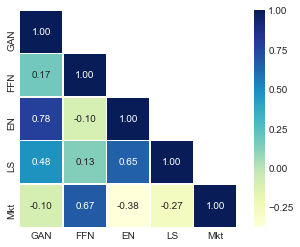

In [41]:
corr_heat_map(df_SDF.loc[300:,['GAN','FFN','EN','LS','Mkt']], plotPath='model_char_shift/model_GAN/plot') ### test

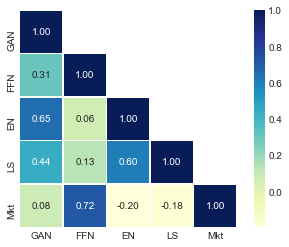

In [42]:
df_SDF = pd.DataFrame({'LS':SDF_LS, 'EN':SDF_Elastic, 'FFN':SDF_FFN, 'GAN':SDF_GAN[:,0], 'Mkt': SDF_MKT})
corr_heat_map(df_SDF.loc[:,['GAN','FFN','EN','LS','Mkt']], plotPath='model_char_shift/model_GAN/plot')

##### Plot Weight As Function of Firm Characteristics

INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/7/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/8/model-best
>==================> Restored checkpoint
INFO:tensorflow:

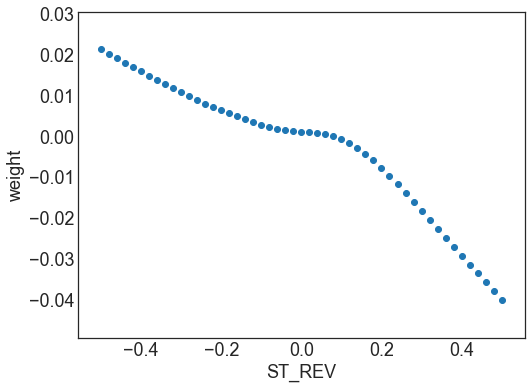

In [7]:
model_plot.plotWeight1DWithChar(sess, dl_test, 'ST_REV')

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4. 1D Curves: 4
Enter variable idx for x (0 - 45, 46 - 223): 43
Enter variable idx for y (0 - 45, 46 - 223): 32
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/6/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring p

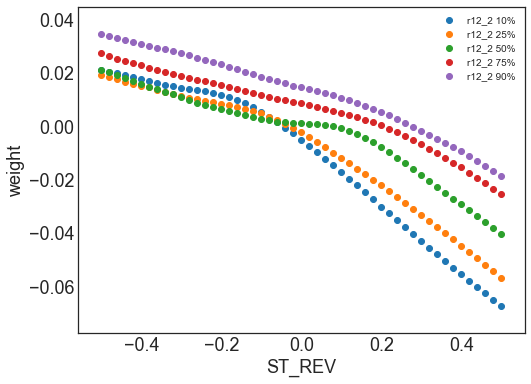

In [9]:
model_plot.plotWeight(sess, dl_test, plotPath='model_char_shift/model_GAN/plot/2D')

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 5
Enter variable idx for x (0 - 45, 46 - 223): 43
Enter variable idx for y (0 - 45, 46 - 223): 18
Enter variable idx for z (0 - 45, 46 - 223): 4
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model

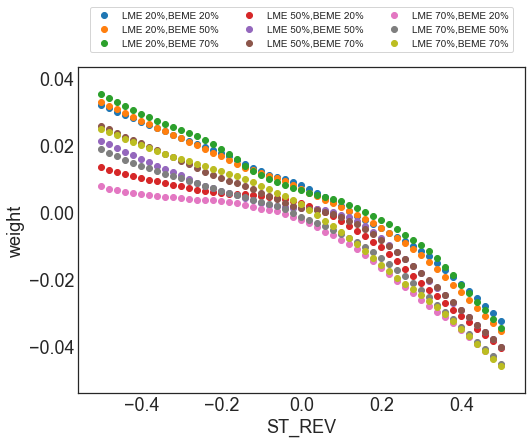

In [15]:
model_plot.plotWeight(sess, dl_test, plotPath='model_char_shift/model_GAN/plot/3D')

In [9]:
# model_plot.plotWeight1DWithChar(sess, dl_test, 'All', plotPath='model_char_shift/model_GAN/plot/1D')

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 2
Enter variable idx for x (0 - 45, 46 - 223): 18
Enter variable idx for y (0 - 45, 46 - 223): 11
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/6/model-best
>==================> Restored

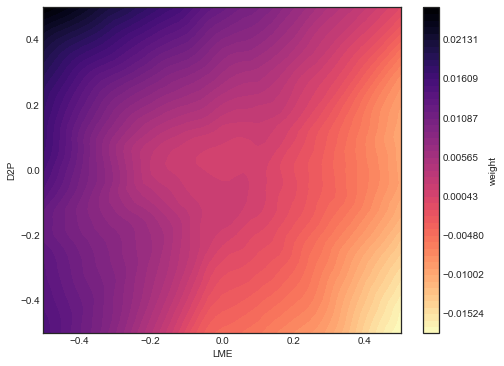

In [8]:
model_plot.plotWeight(sess, dl_test, plotPath='model_char_shift/model_GAN/plot/2D')

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 3
Enter variable idx for x (0 - 45, 46 - 223): 18
Enter variable idx for y (0 - 45, 46 - 223): 11
Enter variable idx for z (0 - 45, 46 - 223): 43
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN/5/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/mode

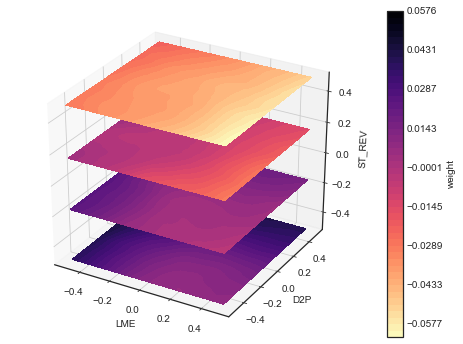

In [9]:
model_plot.plotWeight(sess, dl_test, plotPath='model_char_shift/model_GAN/plot/3D')

##### Plot Beta As Function of Firm Characteristics

>==================> Please enter the idx for the plot you want! 
Please select from 1.1D, 2.2D Contour 3.2D Contour Slice 4.1D Curves (2 Variables) 5.1D Curves (3 Variables): 3
Enter variable idx for x (0 - 45, 46 - 45): 18
Enter variable idx for y (0 - 45, 46 - 45): 11
Enter variable idx for z (0 - 45, 46 - 45): 43
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/1/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/2/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/3/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/4/model-best
>==================> Restored checkpoint
INFO:tensorflow:Restoring parameters from model_char_shift/model_GAN_RF_normalized/5/model-best
>==================> Restored checkpo

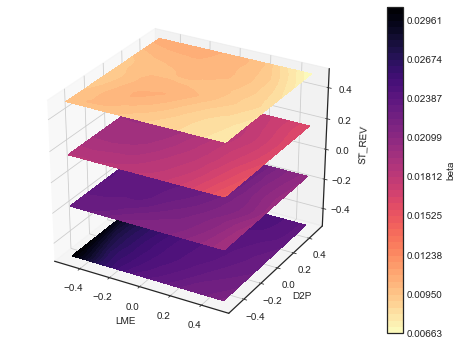

In [16]:
model_plot_RF.plotConditionalReturn(sess, dl_test, plotPath='model_char_shift/model_GAN/plot/beta', label='beta')